In [83]:
import pandas as pd
import numpy as np
from collections import Counter 
import torchvision
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torch.autograd import Variable
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import math
import torch.nn.functional as F
import pickle
import gc
import random
pd.set_option('display.max_colwidth', None)

In [84]:
df = pd.read_csv("/kaggle/input/flickr8k/captions.txt", sep=',')
print(len(df))
display(df.head(3))

40455


image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   

                                                                    caption  
0  A child in a pink dress is climbing up a set of stairs in an entry way .  
1                                     A girl going into a wooden building .  
2                          A little girl climbing into a wooden playhouse .

In [85]:
def remove_single_char_word(word_list):
    lst = []
    for word in word_list:
        if len(word)>1:
            lst.append(word)

    return lst

In [86]:
df['cleaned_caption'] = df['caption'].apply(lambda caption : ['<start>'] + [word.lower() if word.isalpha() else '' for word in caption.split(" ")] + ['<end>'])
df['cleaned_caption']  = df['cleaned_caption'].apply(lambda x : remove_single_char_word(x))

In [87]:
df['seq_len'] = df['cleaned_caption'].apply(lambda x : len(x))
max_seq_len = df['seq_len'].max()
print(max_seq_len)

33


In [88]:
# Padding sequences
df.drop(['seq_len'], axis = 1, inplace = True)
df['cleaned_caption'] = df['cleaned_caption'].apply(lambda caption : caption + ['<pad>']*(max_seq_len-len(caption)) )

In [89]:
display(df.head(2))

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   

                                                                    caption  \
0  A child in a pink dress is climbing up a set of stairs in an entry way .   
1                                     A girl going into a wooden building .   

                                                                                                                                                                                                                               cleaned_caption  
0                       [<start>, child, in, pink, dress, is, climbing, up, set, of, stairs, in, an, entry, way, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]  
1  [<start>, girl, going, into, wooden, building, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]

In [90]:
# Building vocabulary
word_list = df['cleaned_caption'].apply(lambda x : " ".join(x)).str.cat(sep = ' ').split(' ')
word_dict = Counter(word_list)
word_dict =  sorted(word_dict, key=word_dict.get, reverse=True)
vocab_size = len(word_dict)


In [91]:
print(len(word_dict))
print(word_dict[:5])
print(vocab_size)

8360
['<pad>', '<start>', '<end>', 'in', 'the']
8360


In [92]:
index_to_word = {index: word for index, word in enumerate(word_dict)}
word_to_index = {word: index for index, word in enumerate(word_dict)}
print(len(index_to_word), len(word_to_index))

8360 8360


In [93]:
df['text_seq']  = df['cleaned_caption'].apply(lambda caption : [word_to_index[word] for word in caption] )

In [94]:
display(df.head(2))

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   

                                                                    caption  \
0  A child in a pink dress is climbing up a set of stairs in an entry way .   
1                                     A girl going into a wooden building .   

                                                                                                                                                                                                                               cleaned_caption  \
0                       [<start>, child, in, pink, dress, is, climbing, up, set, of, stairs, in, an, entry, way, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]   
1  [<start>, girl, going, into, wooden, building, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]   

                                                                                                                text_seq  
0  [1, 41, 3, 89, 168, 6, 118, 52, 392, 11, 389, 3, 27, 5075, 690, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  
1            [1, 18, 311, 63, 192, 116, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [95]:
# Splitting the data into training and validation sets
df = df.sort_values(by='image')
train = df.iloc[:int(0.9*len(df))]
valid = df.iloc[int(0.9*len(df)):]
train_samples = len(train)
unq_train_imgs = train[['image']].drop_duplicates()
unq_valid_imgs = valid[['image']].drop_duplicates()


In [96]:
# Setting the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [97]:
# Dataset for extracting image features using ResNet-152
class extractImageFeatureResNetDataSet():
    def __init__(self, data):
        self.data = data 
        self.scaler = transforms.Resize([224, 224])
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.to_tensor = transforms.ToTensor()

    def __len__(self):  
        return len(self.data)

    def __getitem__(self, idx):
        image_name = self.data.iloc[idx]['image']
        img_loc = '../input/flickr8k/Images/'+str(image_name)
        img = Image.open(img_loc)
        t_img = self.normalize(self.to_tensor(self.scaler(img)))
 

In [98]:
# Loading ResNet-152 model
resnet152 = torchvision.models.resnet152(pretrained=True).to(device)
resnet152.eval()
list(resnet152._modules)
resNet152Layer4 = resnet152._modules.get('layer4').to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [99]:
# Function to extract image features
def get_vector(t_img):
    t_img = Variable(t_img)
    my_embedding = torch.zeros(1, 2048, 7, 7)  # Adjusted for ResNet-152
    def copy_data(m, i, o):
        my_embedding.copy_(o.data)
    h = resNet152Layer4.register_forward_hook(copy_data)
    resnet152(t_img)
    h.remove()
    return my_embedding


In [100]:
# Extracting and saving image features for the training set
extract_imgFtr_ResNet_train = {}
for image_name, t_img in tqdm(train_ImageDataloader_ResNet):
    t_img = t_img.to(device)
    embdg = get_vector(t_img)
    extract_imgFtr_ResNet_train[image_name[0]] = embdg


  0%|          | 0/7282 [00:00<?, ?it/s]

In [101]:
a_file = open("./EncodedImageTrainResNet.pkl", "wb")
pickle.dump(extract_imgFtr_ResNet_train, a_file)
a_file.close()

In [102]:
extract_imgFtr_ResNet_valid = {}
for image_name, t_img in tqdm(valid_ImageDataloader_ResNet):
    t_img = t_img.to(device)
    embdg = get_vector(t_img)
 
    extract_imgFtr_ResNet_valid[image_name[0]] = embdg

  0%|          | 0/810 [00:00<?, ?it/s]

In [103]:
a_file = open("./EncodedImageValidResNet.pkl", "wb")
pickle.dump(extract_imgFtr_ResNet_valid, a_file)
a_file.close()

In [104]:
class FlickerDataSetResnet():
    def __init__(self, data, pkl_file):
        self.data = data
        self.encodedImgs = pd.read_pickle(pkl_file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
    
        caption_seq = self.data.iloc[idx]['text_seq']
        target_seq = caption_seq[1:]+[0]

        image_name = self.data.iloc[idx]['image']
        image_tensor = self.encodedImgs[image_name]
        image_tensor = image_tensor.permute(0,2,3,1)
        image_tensor_view = image_tensor.view(image_tensor.size(0), -1, image_tensor.size(3))

        return torch.tensor(caption_seq), torch.tensor(target_seq), image_tensor_view

In [105]:
train_dataset_resnet = FlickerDataSetResnet(train, 'EncodedImageTrainResNet.pkl')
train_dataloader_resnet = DataLoader(train_dataset_resnet, batch_size = 32, shuffle=True)

In [106]:
valid_dataset_resnet = FlickerDataSetResnet(valid, 'EncodedImageValidResNet.pkl')
valid_dataloader_resnet = DataLoader(valid_dataset_resnet, batch_size = 32, shuffle=True)

In [107]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=max_seq_len):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        

    def forward(self, x):
        if self.pe.size(0) < x.size(0):
            self.pe = self.pe.repeat(x.size(0), 1, 1).to(device)
        self.pe = self.pe[:x.size(0), : , : ]
        
        x = x + self.pe
        return self.dropout(x)

In [113]:
class ImageCaptionModel(nn.Module):
    def __init__(self, n_head, n_decoder_layer, vocab_size, embedding_size, encoded_image_dim):
        super(ImageCaptionModel, self).__init__()
        self.pos_encoder = PositionalEncoding(embedding_size, 0.1)
        self.TransformerDecoderLayer = nn.TransformerDecoderLayer(d_model=embedding_size, nhead=n_head)
        self.TransformerDecoder = nn.TransformerDecoder(decoder_layer=self.TransformerDecoderLayer, num_layers=n_decoder_layer)
        self.embedding_size = embedding_size  # Store embedding_size as an attribute
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.encoder_proj = nn.Linear(encoded_image_dim, embedding_size)
        self.last_linear_layer = nn.Linear(embedding_size, vocab_size)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.last_linear_layer.bias.data.zero_()
        self.last_linear_layer.weight.data.uniform_(-initrange, initrange)

    def generate_Mask(self, size, decoder_inp):
        decoder_input_mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
        decoder_input_mask = decoder_input_mask.float().masked_fill(decoder_input_mask == 0, float('-inf')).masked_fill(decoder_input_mask == 1, float(0.0))

        decoder_input_pad_mask = decoder_inp.float().masked_fill(decoder_inp == 0, float(0.0)).masked_fill(decoder_inp > 0, float(1.0))
        decoder_input_pad_mask_bool = decoder_inp == 0

        return decoder_input_mask, decoder_input_pad_mask, decoder_input_pad_mask_bool

    def forward(self, encoded_image, decoder_inp):
        # Project encoded_image to match embedding_size
        encoded_image = self.encoder_proj(encoded_image).permute(1, 0, 2)
        
        # Embed decoder input and apply positional encoding
        decoder_inp_embed = self.embedding(decoder_inp) * math.sqrt(self.embedding_size)
        decoder_inp_embed = self.pos_encoder(decoder_inp_embed).permute(1, 0, 2)
        
        # Generate masks
        decoder_input_mask, decoder_input_pad_mask, decoder_input_pad_mask_bool = self.generate_Mask(decoder_inp.size(1), decoder_inp)
        decoder_input_mask = decoder_input_mask.to(device)
        decoder_input_pad_mask = decoder_input_pad_mask.to(device)
        decoder_input_pad_mask_bool = decoder_input_pad_mask_bool.to(device)
        
        # Pass through the Transformer decoder
        decoder_output = self.TransformerDecoder(tgt=decoder_inp_embed, memory=encoded_image, tgt_mask=decoder_input_mask, tgt_key_padding_mask=decoder_input_pad_mask_bool)
        
        # Generate final output
        final_output = self.last_linear_layer(decoder_output)

        return final_output, decoder_input_pad_mask


In [109]:
EPOCH = 30

In [114]:
# Assuming the encoded image dimension is 2048
ictModel = ImageCaptionModel(n_head=16, n_decoder_layer=4, vocab_size=vocab_size, embedding_size=512, encoded_image_dim=2048).to(device)

optimizer = torch.optim.Adam(ictModel.parameters(), lr=0.00001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, patience=2, verbose=True)
criterion = torch.nn.CrossEntropyLoss(reduction='none')
min_val_loss = float('Inf')  # Changed np.float('Inf') to float('Inf')


In [115]:
for epoch in tqdm(range(EPOCH)):
    total_epoch_train_loss = 0
    total_epoch_valid_loss = 0
    total_train_words = 0
    total_valid_words = 0
    ictModel.train()

    ### Train Loop
    for caption_seq, target_seq, image_embed in train_dataloader_resnet:

        optimizer.zero_grad()

        image_embed = image_embed.squeeze(1).to(device)
        caption_seq = caption_seq.to(device)
        target_seq = target_seq.to(device)

        output, padding_mask = ictModel.forward(image_embed, caption_seq)
        output = output.permute(1, 2, 0)

        loss = criterion(output,target_seq)

        loss_masked = torch.mul(loss, padding_mask)

        final_batch_loss = torch.sum(loss_masked)/torch.sum(padding_mask)

        final_batch_loss.backward()
        optimizer.step()
        total_epoch_train_loss += torch.sum(loss_masked).detach().item()
        total_train_words += torch.sum(padding_mask)

 
    total_epoch_train_loss = total_epoch_train_loss/total_train_words
  

    ### Eval Loop
    ictModel.eval()
    with torch.no_grad():
        for caption_seq, target_seq, image_embed in valid_dataloader_resnet:

            image_embed = image_embed.squeeze(1).to(device)
            caption_seq = caption_seq.to(device)
            target_seq = target_seq.to(device)

            output, padding_mask = ictModel.forward(image_embed, caption_seq)
            output = output.permute(1, 2, 0)

            loss = criterion(output,target_seq)

            loss_masked = torch.mul(loss, padding_mask)

            total_epoch_valid_loss += torch.sum(loss_masked).detach().item()
            total_valid_words += torch.sum(padding_mask)

    total_epoch_valid_loss = total_epoch_valid_loss/total_valid_words
  
    print("Epoch -> ", epoch," Training Loss -> ", total_epoch_train_loss.item(), "Eval Loss -> ", total_epoch_valid_loss.item() )
  
    if min_val_loss > total_epoch_valid_loss:
        print("Writing Model at epoch ", epoch)
        torch.save(ictModel, './BestModel')
        min_val_loss = total_epoch_valid_loss
  

    scheduler.step(total_epoch_valid_loss.item())

  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:5193: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch ->  0  Training Loss ->  5.210454940795898 Eval Loss ->  4.325016975402832
Writing Model at epoch  0
Epoch ->  1  Training Loss ->  4.162698745727539 Eval Loss ->  3.9156954288482666
Writing Model at epoch  1
Epoch ->  2  Training Loss ->  3.8397135734558105 Eval Loss ->  3.7183754444122314
Writing Model at epoch  2
Epoch ->  3  Training Loss ->  3.641695499420166 Eval Loss ->  3.587228298187256
Writing Model at epoch  3
Epoch ->  4  Training Loss ->  3.4979586601257324 Eval Loss ->  3.4967291355133057
Writing Model at epoch  4
Epoch ->  5  Training Loss ->  3.381035089492798 Eval Loss ->  3.4290122985839844
Writing Model at epoch  5
Epoch ->  6  Training Loss ->  3.2851462364196777 Eval Loss ->  3.3648147583007812
Writing Model at epoch  6
Epoch ->  7  Training Loss ->  3.20159912109375 Eval Loss ->  3.3235883712768555
Writing Model at epoch  7
Epoch ->  8  Training Loss ->  3.127805709838867 Eval Loss ->  3.283259868621826
Writing Model at epoch  8
Epoch ->  9  Training Loss ->

In [117]:
model = torch.load('./BestModel')
start_token = word_to_index['<start>']
end_token = word_to_index['<end>']
pad_token = word_to_index['<pad>']
max_seq_len = 33
print(start_token, end_token, pad_token)

1 2 0


/tmp/ipykernel_36/1634034949.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('./BestModel')


In [118]:
valid_img_embed = pd.read_pickle('EncodedImageValidResNet.pkl')

In [135]:
import random
from nltk.translate.bleu_score import sentence_bleu

def generate_caption(K, img_nm): 
    img_loc = '../input/flickr8k/Images/' + str(img_nm)
    image = Image.open(img_loc).convert("RGB")
    plt.imshow(image)

    model.eval() 
    valid_img_df = valid[valid['image'] == img_nm]
    actual_captions = valid_img_df['caption'].tolist()
    print("Actual Captions : ")
    print(actual_captions)

    img_embed = valid_img_embed[img_nm].to(device)
    img_embed = img_embed.permute(0, 2, 3, 1)
    img_embed = img_embed.view(img_embed.size(0), -1, img_embed.size(3))

    input_seq = [pad_token] * max_seq_len
    input_seq[0] = start_token
    input_seq = torch.tensor(input_seq).unsqueeze(0).to(device)

    predicted_sentence = []
    with torch.no_grad():
        for eval_iter in range(0, max_seq_len):
            output, padding_mask = model.forward(img_embed, input_seq)
            output = output[eval_iter, 0, :]
            values = torch.topk(output, K).values.tolist()
            indices = torch.topk(output, K).indices.tolist()
            next_word_index = random.choices(indices, values, k=1)[0]
            next_word = index_to_word[next_word_index]
            input_seq[:, eval_iter + 1] = next_word_index

            if next_word == '<end>':
                break

            predicted_sentence.append(next_word)

    predicted_caption = " ".join(predicted_sentence + ['.'])
    print("\nPredicted caption: ")
    print(predicted_caption)
    
    # Tokenize the actual and predicted captions for BLEU score calculation
    actual_captions_tokenized = [caption.split() for caption in actual_captions]
    predicted_caption_tokenized = predicted_caption.split()

    # Compute BLEU score
    bleu_score = sentence_bleu(actual_captions_tokenized, predicted_caption_tokenized)
    print(f"\nBLEU score: {bleu_score}")

    return predicted_caption, bleu_score


Actual Captions : 
['Young child in pink top and purple pants clutching a turquoise guard rail .', 'A very young girl is walking on a playground .', 'The little girl is playing at the playground .', 'A little girl in pink and purple stands on a playground .', 'A female toddler wearing a pink shirt is playing on a playground .']

Predicted caption: 
little girl in pink shirt is playing on playground .

BLEU score: 0.6985342056580097
BLEU Score: 0.6985342056580097


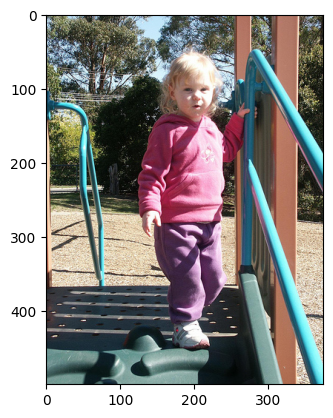

In [139]:
predicted_caption, bleu_score = generate_caption(1, unq_valid_imgs.iloc[50]['image'])
print(f"BLEU Score: {bleu_score}")

Actual Captions : 
['Young child in pink top and purple pants clutching a turquoise guard rail .', 'A very young girl is walking on a playground .', 'The little girl is playing at the playground .', 'A little girl in pink and purple stands on a playground .', 'A female toddler wearing a pink shirt is playing on a playground .']

Predicted caption: 
little boy is sitting on playground .

BLEU score: 0.4414139365346591
BLEU Score: 0.4414139365346591


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


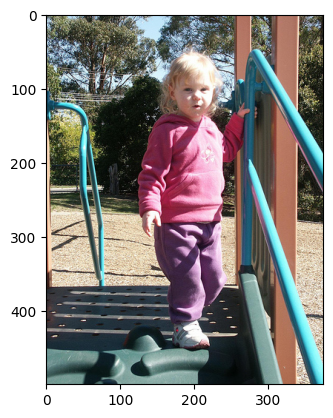

In [140]:
predicted_caption, bleu_score = generate_caption(2, unq_valid_imgs.iloc[50]['image'])
print(f"BLEU Score: {bleu_score}")

Actual Captions : 
['closeup of a brown dog in the water holding a very large stick .', 'A swimming dog with a small branch in its mouth .', 'A dog swimming with a stick in its mouth .', 'A brown dog carrying a stick in its mouth .', 'A dog has its head coming up from the water as it holds a stick .']

Predicted caption: 
brown dog is swimming through water .

BLEU score: 0.3826519862236253
BLEU Score: 0.3826519862236253


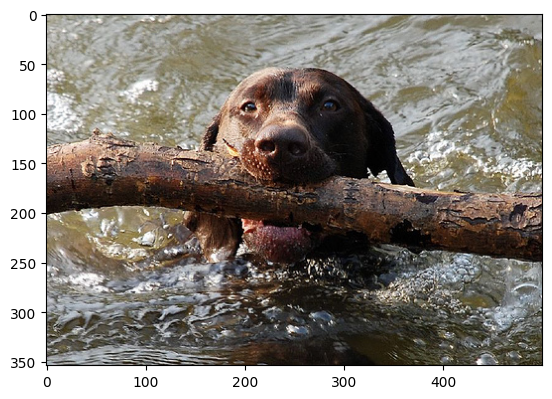

In [141]:
predicted_caption, bleu_score = generate_caption(1, unq_valid_imgs.iloc[111]['image'])
print(f"BLEU Score: {bleu_score}")

Actual Captions : 
['closeup of a brown dog in the water holding a very large stick .', 'A swimming dog with a small branch in its mouth .', 'A dog swimming with a stick in its mouth .', 'A brown dog carrying a stick in its mouth .', 'A dog has its head coming up from the water as it holds a stick .']

Predicted caption: 
dog swimming through river with water .

BLEU score: 0.3826519862236253
BLEU Score: 0.3826519862236253


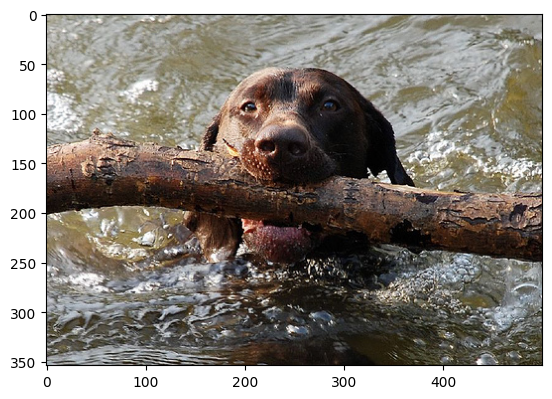

In [142]:
predicted_caption, bleu_score = generate_caption(2, unq_valid_imgs.iloc[111]['image'])
print(f"BLEU Score: {bleu_score}")

Actual Captions : 
['A black and brown dog shakes water off of itself .', 'a brown and black dog shaking the water of himself', 'A brown and black dog with a red and blue collar stands on a brown grassy surface with water droplets all around .', 'A dog stretches its neck out as it shakes off dust .', 'A wet dog shaking off excess water in a field .']

Predicted caption: 
black and brown dog is playing with toy .

BLEU score: 0.29558013016570783
BLEU Score: 0.29558013016570783


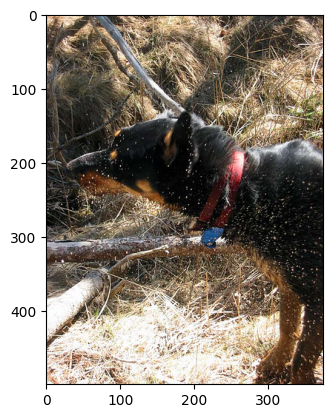

In [143]:
predicted_caption, bleu_score = generate_caption(1, unq_valid_imgs.iloc[129]['image'])
print(f"BLEU Score: {bleu_score}")

Actual Captions : 
['A boy and a girl are riding in a red seat on a fairground ride .', 'A girl and a boy enjoy a fast amusement ride .', 'A young girl and boy on a ride at an amusement park .', 'Two children ride in a red seat on a fair ride and smile .', 'Two kids are on a fair ride and are slipping to one side of the car .']

Predicted caption: 
two children are sitting in red plastic car .

BLEU score: 0.4302241682304372
BLEU Score: 0.4302241682304372


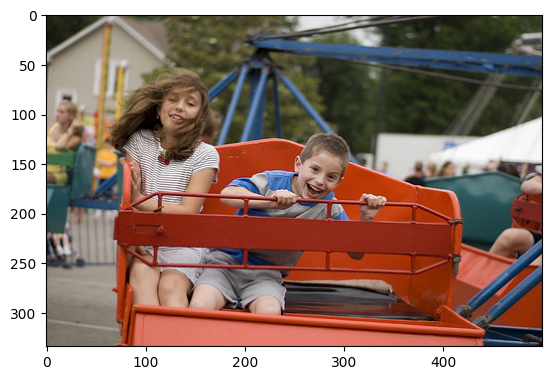

In [144]:
predicted_caption, bleu_score = generate_caption(1, unq_valid_imgs.iloc[392]['image'])
print(f"BLEU Score: {bleu_score}")

Actual Captions : 
['A man dressed in blue holds a sign while standing behind a couple of trees and in front of a large concrete wall with red writing on it .', 'A man holds up a cardboard sign near a wall with red graffiti .', 'A man in a black jacket is standing between two trees holding up a sign .', 'A man stands on the side of the road , holding a cardboard sign .', 'A man stands with a cardboard sign on a road']

Predicted caption: 
woman is standing on the edge of the water and is holding her hand .

BLEU score: 0.5988059642324198
BLEU Score: 0.5988059642324198


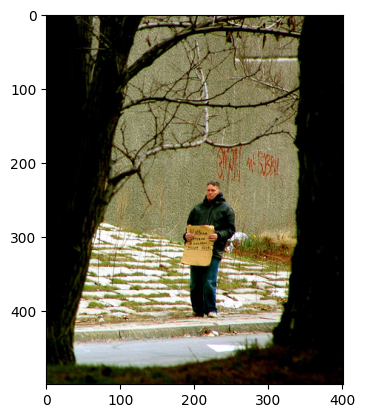

In [145]:
predicted_caption, bleu_score = generate_caption(1, unq_valid_imgs.iloc[64]['image'])
print(f"BLEU Score: {bleu_score}")

Actual Captions : 
['There is a person standing a mountain that has some interesting shapes .', 'The night sky in the desert .', 'Interesting rock formations in the desert landscape , with stars above .', 'A person standing on a ridge in the desert .', 'A person in the distance hikes among hoodoos with stars visible in the sky .']

Predicted caption: 
man stands on rocky cliff .

BLEU score: 0.6431870218238024
BLEU Score: 0.6431870218238024


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


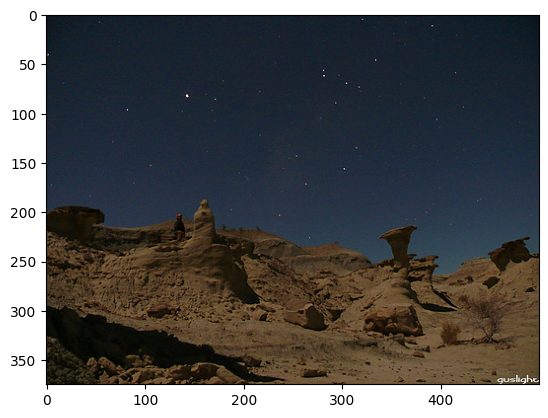

In [146]:
predicted_caption, bleu_score = generate_caption(1, unq_valid_imgs.iloc[33]['image'])
print(f"BLEU Score: {bleu_score}")

Actual Captions : 
['A dog is walking near a body of water .', "A big , black dog is walking along the water 's edge .", 'A black dog and its reflection are seen near a pond ringed by dry foliage .', 'A black dog is walking beside water in the woods .', "A black dog walks along a marsh 's edge ."]

Predicted caption: 
dog is jumping into lake .

BLEU score: 0.288715663092199
BLEU Score: 0.288715663092199


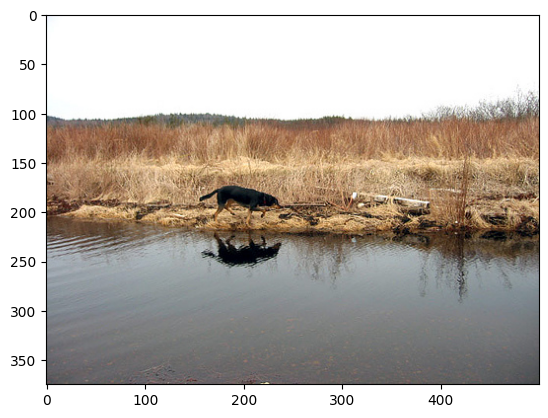

In [147]:
predicted_caption, bleu_score = generate_caption(1, unq_valid_imgs.iloc[88]['image'])
print(f"BLEU Score: {bleu_score}")

Actual Captions : 
['A black dog and a black dog are fighting over a soccer ball .', 'two dogs are gnawing at a blue and yellow ball .', 'Two dogs play and fight over a blue ball .', 'Two dogs playing with a ball .', 'Two dogs playing with a blue and green ball .']

Predicted caption: 
black and white dog is playing with ball in the grass .

BLEU score: 0.47987820666906633
BLEU Score: 0.47987820666906633


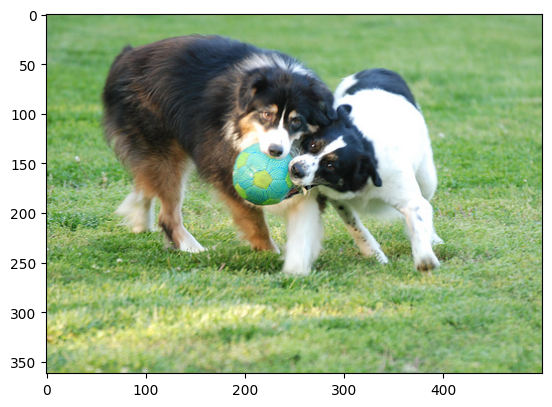

In [148]:
predicted_caption, bleu_score = generate_caption(1, unq_valid_imgs.iloc[234]['image'])
print(f"BLEU Score: {bleu_score}")

Actual Captions : 
['A man is playing with a fire baton in the day light .', 'A man juggling fire .', 'A man stands near a playground .', 'Man throws flames outside .', 'The guy is holding a black stick in front of a playground .']

Predicted caption: 
man in black suit and black suit is walking down dirt road .

BLEU score: 0.7875110621102679
BLEU Score: 0.7875110621102679


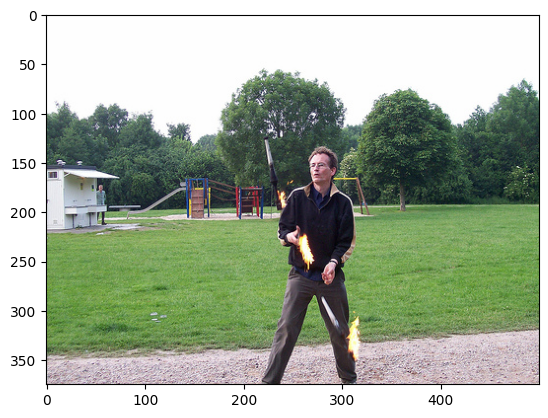

In [149]:
predicted_caption, bleu_score = generate_caption(1, unq_valid_imgs.iloc[412]['image'])
print(f"BLEU Score: {bleu_score}")

Actual Captions : 
['A black dog and a brown dog close together .', 'A brown dog and a black dog on a dirt path .', 'One brown and one mostly black dog are either playing or fighting .', 'Two dogs are playing together outside .', 'Two dogs , face to face , on a dirt road .']

Predicted caption: 
two dogs are playing in the grass .

BLEU score: 0.392814650900513
BLEU Score: 0.392814650900513


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


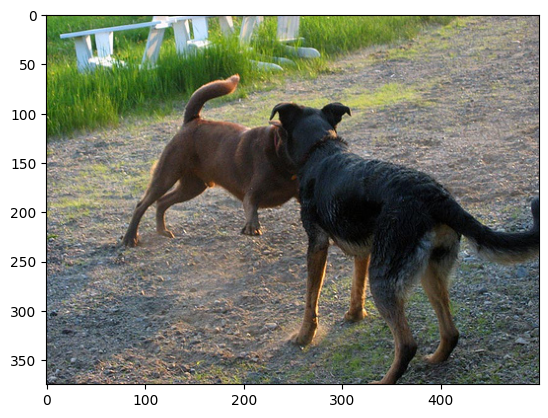

In [150]:
predicted_caption, bleu_score = generate_caption(1, unq_valid_imgs.iloc[333]['image'])
print(f"BLEU Score: {bleu_score}")

Actual Captions : 
['A black dog is being chase by two brown dogs on the beach .', 'A black dog is followed by two brown dogs over sand .', 'A group of three dogs running across a rocky , sandy beach .', 'One black and white dog and two brown and white dogs moving on sand .', 'Three dogs are running across a sandy landscape .']

Predicted caption: 
three dogs are running on sand .

BLEU score: 0.5709992642354627
BLEU Score: 0.5709992642354627


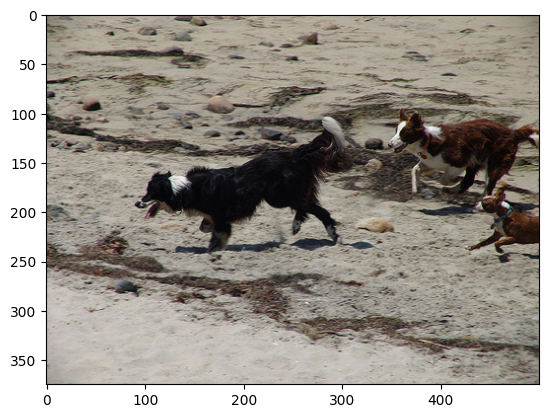

In [158]:
predicted_caption, bleu_score = generate_caption(1, unq_valid_imgs.iloc[232]['image'])
print(f"BLEU Score: {bleu_score}")